In [25]:
from google.colab import files
uploaded = files.upload()

Saving disease_diagnosis.csv to disease_diagnosis (1).csv


In [26]:
!pip install datasketch
!pip install hmac

  Using cached hmac-20101005.tar.gz (4.5 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of hmac to determine which version is compatible with other requirements. This could take a while.
ERROR: Ignored the following yanked versions: 20081119
ERROR: Could not find a version that satisfies the requirement hashlib (from hmac) (from versions: none)
ERROR: No matching distribution found for hashlib


In [27]:
import pandas as pd
from datasketch import MinHash
import hmac
import hashlib
import random


data = pd.read_csv('disease_diagnosis.csv')
data = data.dropna()  # Remove missing values
data = data.drop_duplicates()  # Remove duplicates



In [28]:
data.columns

Index(['Patient_ID', 'Age', 'Gender', 'Symptom_1', 'Symptom_2', 'Symptom_3',
       'Heart_Rate_bpm', 'Body_Temperature_C', 'Blood_Pressure_mmHg',
       'Oxygen_Saturation_%', 'Diagnosis', 'Severity', 'Treatment_Plan'],
      dtype='object')

In [29]:
# 2. LSH Signature Generation
minhashes = []
for _, row in data.iterrows():
    m = MinHash(num_perm=128)
    for feature in row[['Age', 'Gender', 'Symptom_1', 'Symptom_2', 'Symptom_3',
       'Heart_Rate_bpm', 'Body_Temperature_C', 'Blood_Pressure_mmHg',
       'Oxygen_Saturation_%']]:
        m.update(str(feature).encode('utf8'))
    minhashes.append(m)



In [31]:
data_subset = data[['Patient_ID', 'Age', 'Gender', 'Symptom_1', 'Symptom_2', 'Symptom_3',
                    'Heart_Rate_bpm', 'Body_Temperature_C', 'Blood_Pressure_mmHg',
                    'Oxygen_Saturation_%', 'Diagnosis', 'Severity', 'Treatment_Plan']].head(2)

# Converting the subset of the DataFrame to the desired format
formatted_data = {
    column: data_subset[column].tolist()
    for column in data_subset.columns
}

# Creating a new DataFrame in the desired format
new_data = pd.DataFrame(formatted_data)

In [32]:
def hmac_sha256(new_data, key):
    # The error was here: It should be 'new_data' instead of 'data'
    # Now it correctly uses the data passed to the function
    h = hmac.new(key.encode('utf8'), new_data, hashlib.sha256)
    return h.hexdigest()

# Generate a random secret key
secret_key = ''.join(random.choices('abcdefghijklmnopqrstuvwxyz0123456789', k=32))

# Calculate HMAC for each data point
for _, row in data.iterrows():
    data_str = str(row).encode('utf8')  # Encode the row as bytes
    # Pass 'data_str' as the first argument, which is the data to be hashed
    hmac_value = hmac_sha256(data_str, secret_key)
    # Transmit data_str and hmac_value securely
    print("Data:", data_str)
    print("HMAC:", hmac_value)

Data: b'Patient_ID                               1\nAge                                     74\nGender                                Male\nSymptom_1                          Fatigue\nSymptom_2                      Sore throat\nSymptom_3                            Fever\nHeart_Rate_bpm                          69\nBody_Temperature_C                    39.4\nBlood_Pressure_mmHg                 132/91\nOxygen_Saturation_%                     94\nDiagnosis                              Flu\nSeverity                          Moderate\nTreatment_Plan         Medication and rest\nName: 0, dtype: object'
HMAC: b3566dfee7845351f90151c765640a6e4dc8cd9ef3a881c54d675fe279106bff
Data: b'Patient_ID                           2\nAge                                 66\nGender                          Female\nSymptom_1                  Sore throat\nSymptom_2                      Fatigue\nSymptom_3                        Cough\nHeart_Rate_bpm                      95\nBody_Temperature_C                39.

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Patient_ID           2000 non-null   int64  
 1   Age                  2000 non-null   int64  
 2   Gender               2000 non-null   object 
 3   Symptom_1            2000 non-null   object 
 4   Symptom_2            2000 non-null   object 
 5   Symptom_3            2000 non-null   object 
 6   Heart_Rate_bpm       2000 non-null   int64  
 7   Body_Temperature_C   2000 non-null   float64
 8   Blood_Pressure_mmHg  2000 non-null   object 
 9   Oxygen_Saturation_%  2000 non-null   int64  
 10  Diagnosis            2000 non-null   object 
 11  Severity             2000 non-null   object 
 12  Treatment_Plan       2000 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 203.2+ KB


In [34]:
# 4. RSSI-Based Key Derivation
def derive_key_from_rssi(rssi):
    # Implement a suitable key derivation function
    # For example, use a cryptographic hash function like SHA-256
    key = hashlib.sha256(str(rssi).encode('utf8')).hexdigest()
    return key



In [61]:
from sklearn.preprocessing import OneHotEncoder

In [57]:
# prompt: USE RANDOM FOREST FOR ANOMALY DETECTION

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

data[['Systolic_BP', 'Diastolic_BP']] = data['Blood_Pressure_mmHg'].str.split('/', expand=True).astype(float)

# Update X to use the new numerical columns
# Prepare the data for anomaly detection
X = data.drop('Diagnosis', axis=1)  # Features
label_encoder = LabelEncoder()
data['Diagnosis_Encoded'] = label_encoder.fit_transform(data['Diagnosis'])  # Create a new encoded column
y = data['Diagnosis_Encoded']

X = X.drop('Blood_Pressure_mmHg', axis=1)

# Convert categorical features to numerical using one-hot encoding
# Include 'Treatment_Plan' in the list of categorical features
categorical_features = ['Gender', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Severity', 'Treatment_Plan']
# Use OneHotEncoder for categorical features including Severity
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for RandomForest
encoded_data = encoder.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))


# Drop original categorical features and add encoded features
X = X.drop(categorical_features, axis=1)
X = pd.concat([X, encoded_df], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        58
           3       1.00      1.00      1.00       238
           4       1.00      1.00      1.00        11

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



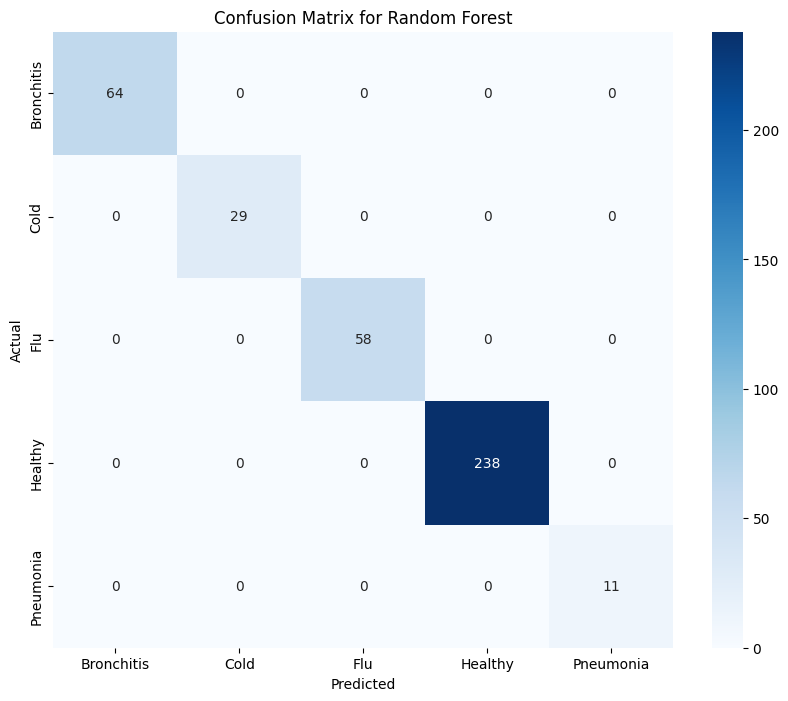

In [59]:
# prompt: confusion matrix for random forest model

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from the previous code

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [65]:
# prompt: accuracy score for random forest

from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100}")

Accuracy: 100.0


In [35]:
from sklearn.ensemble import IsolationForest

In [36]:
# Convert 'Blood_Pressure_mmHg' to systolic and diastolic columns
data[['Systolic_BP', 'Diastolic_BP']] = data['Blood_Pressure_mmHg'].str.split('/', expand=True).astype(float)

# Update X to use the new numerical columns
X = data[['Heart_Rate_bpm', 'Body_Temperature_C', 'Systolic_BP', 'Diastolic_BP',
       'Oxygen_Saturation_%']]

# Now you can proceed with fitting the IsolationForest model
clf = IsolationForest(contamination='auto')
clf.fit(X)

# Predict anomalies
y_pred = clf.predict(X)
data['anomaly'] = y_pred

In [63]:
# prompt: accuracy for model

from sklearn.metrics import accuracy_score

# Assuming 'y_true' contains the true labels (0 for normal, -1 for anomaly)
# and 'y_pred' contains the predicted labels from the IsolationForest model.
# Replace these with your actual true labels and predictions.

# Example:
# Assuming the 'Diagnosis' column indicates the true disease state
# (You'll need to define what constitutes "normal" in your case).

# Convert 'Diagnosis' to numerical labels (example: 1 for disease, 0 for no disease).
# Replace this with your actual mapping of diagnosis to labels.
data['Diagnosis_numeric'] = data['Diagnosis'].apply(lambda x: 1 if x != 'No Disease' else 0)

# You might want to consider creating a more sophisticated mapping based on disease severity or other factors
y_true = data['Diagnosis_numeric'] # Replace 'Diagnosis_numeric' with your actual true label column.

accuracy = accuracy_score(y_true, data['anomaly'])  # Assuming your anomaly labels are in 'anomaly' column.
print(f"Accuracy: {accuracy*100}")

Accuracy: 26.450000000000003


In [64]:
# prompt: USE Decision tree FOR ANOMALY DETECTION

from sklearn.tree import DecisionTreeClassifier

# ... (Your existing code) ...

# Use Decision Tree for anomaly detection
clf_dt = DecisionTreeClassifier() # You can tune hyperparameters here
clf_dt.fit(X, y) # Use the same X and y as IsolationForest

# Predict anomalies
y_pred_dt = clf_dt.predict(X)
data['anomaly_dt'] = y_pred_dt # Store predictions in a new column


# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_true, data['anomaly_dt'])
print(f"Decision Tree Accuracy: {accuracy_dt*100}")

# ... (Rest of your code) ...

Decision Tree Accuracy: 8.15
